# Simulation

In [113]:
library(cowplot)
library(dplyr)
library(pander)
library(ggplot2)
library(purrr)
library(tidyverse)
library(randomForest)
library(tidyr)
library(veesa)
library(ggplot2)
library(patchwork)
library(neuralnet)
library(reticulate)
library(caret)
library(grid)
library(keras3)
library(tensorflow)
tf$config$list_physical_devices("CPU")
options(warn=-1)

[[1]]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [114]:
# Specify a color palette
color_pal = wesanderson::wes_palette("Zissou1", 5, type = "continuous")

# Specify colors for PC direction plots
col_plus1 = "#784D8C"
col_plus2 = "#A289AE"
col_minus1 = "#EA9B44"
col_minus2 = "#EBBC88"
col_pcdir_1sd = c(col_plus1, "black", col_minus1)
col_pcdir_2sd = c(col_plus2, col_plus1, "black", col_minus1, col_minus2)

In [115]:
set.seed(36)
sim_data = simulate_functions(M = 100, N = 75, seed = 36) # 100 x 75 = 7500 rows

In [116]:
printer_data <- sim_data %>%
  select(id, t, y) %>%         
  rename(
    printer = id,              
    spectra = t,               
    intensity = y
  )

# Scale data like Raman printer
printer_data$spectra <- printer_data$spectra * (2000 - 200) + 200
printer_data$intensity <- printer_data$intensity * 1000000000


# Noise
if (noise == 1) {
  printer_data <- printer_data %>%
    group_by(printer) %>%
    mutate(
      intensity = intensity +
        rnorm(n(), sd = intensity * 0.15) +     # Gaussian noise (sensor noise)
        5000 * sin(2 * pi * spectra / 300) +    # baseline drift (fluorescence effect)
        runif(n(), -2000, 2000)                 # random instrument offset
    ) %>%
    ungroup()
}

head(printer_data)

,printer,spectra,intensity
,<chr>,<dbl>,<dbl>
1,1,200.0000,10.05392
2,1,224.3243,49.06083
3,1,248.6486,222.54149
4,1,272.9730,938.34728
5,1,297.2973,3677.83914
6,1,321.6216,13399.80194


id = Printer ID (All different printers)

t = Wavenumber (cm⁻¹) in Raman spectra

y = Intensity at each wavenumber

In [117]:
# Generate Replicates: each printer has R different measurements
R <- 7  # same as the paper: each printer is measured 7 times (cyan/magenta/yellow used later)
replicated_data <- printer_data %>%
  group_by(printer) %>%
  group_split() %>%                     # split into a list of 100 groups
  map_df(function(df) {                 # loop through each printer
    bind_rows(lapply(1:R, function(r) {
      df %>%
        mutate(
          replicate = r,
          intensity = intensity + rnorm(n(), sd = intensity * 0.05)  # 5% noise
        )
    }))
  })

if (noise == 1) {
    replicated_data <- printer_data %>%
    group_by(printer) %>%
    group_split() %>%
    map_df(function(df) {
      bind_rows(lapply(1:R, function(r) {
      df %>%
        mutate(
          replicate = r,
          intensity = intensity + rnorm(n(), sd = abs(intensity) * 0.05) # dùng abs()
        )
    }))
  })

}


In [118]:
cat("✔ Rows:", nrow(replicated_data), "\n")
cat("✔ Printers:", length(unique(replicated_data$printer)), "\n")
cat("✔ Replicates per printer:", table(replicated_data$replicate)[1], "\n")
head(replicated_data)

✔ Rows: 52500 
✔ Printers: 100 
✔ Replicates per printer: 7500 


printer,spectra,intensity,replicate
<chr>,<dbl>,<dbl>,<int>
1,200.0000,9.377504,1
1,224.3243,47.663054,1
1,248.6486,223.204123,1
1,272.9730,871.026053,1
1,297.2973,3713.935938,1
1,321.6216,13417.713287,1


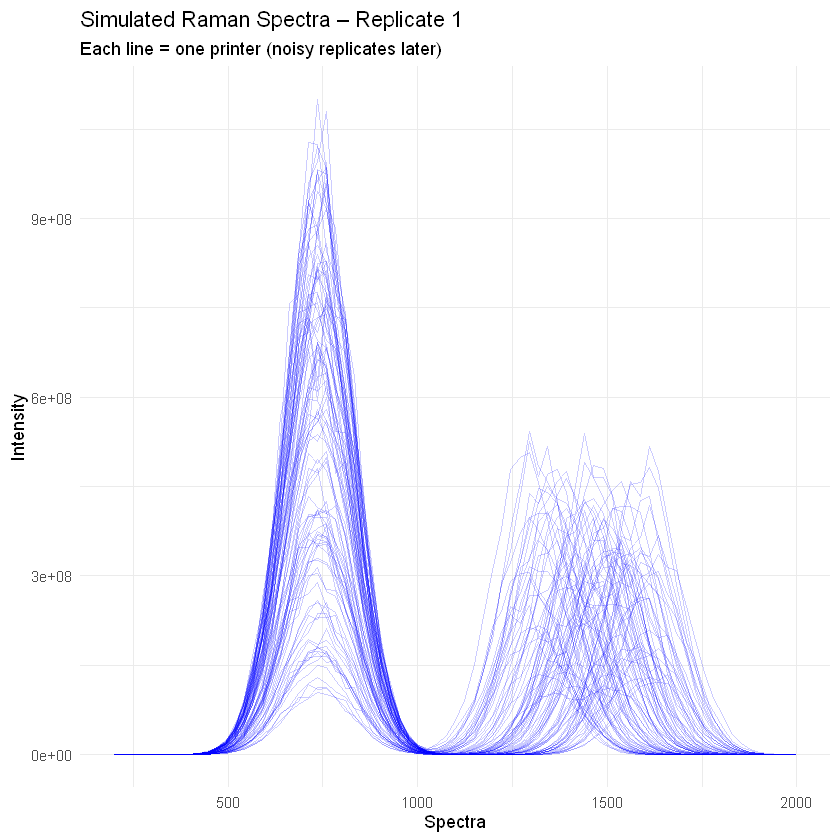

In [119]:
# Plot all curves in sim_data
ggplot(replicated_data %>% filter(replicate == 1),
       aes(x = spectra, y = intensity, group = printer)) +
  geom_line(alpha = 0.2, color = "blue") +
  labs(title = "Simulated Raman Spectra – Replicate 1",
       subtitle = "Each line = one printer (noisy replicates later)",
       x = "Spectra", y = "Intensity") +
  theme_minimal()

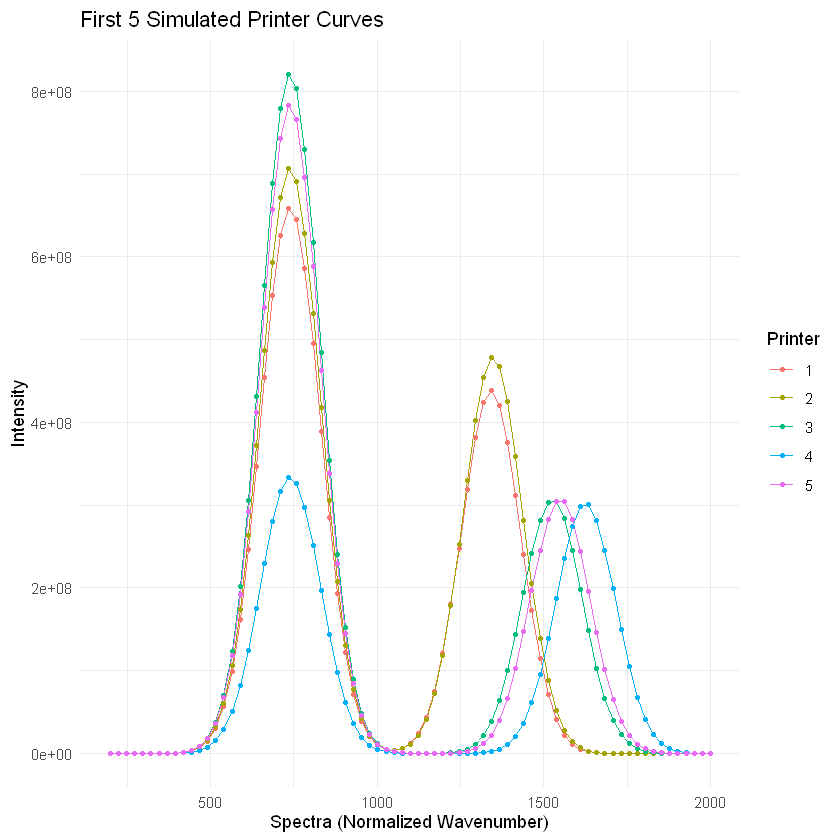

In [120]:
num <- 5
first_5_ids <- head(unique(printer_data$printer), num)

ggplot(printer_data %>% filter(printer %in% first_5_ids),
       aes(x = spectra, y = intensity, color = factor(printer), group = printer)) +
  geom_line(linewidth = 0.4) +
  geom_point(size = 1) +
  labs(
    title = paste("First", num, "Simulated Printer Curves"),
    x = "Spectra (Normalized Wavenumber)", 
    y = "Intensity",
    color = "Printer"
  ) +
  theme_minimal()